In [2]:
import seaborn as sns
from matplotlib import pyplot as plt
import csv
import pandas as pd
import os
import json
from collections import defaultdict,Counter
import gzip

In [3]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

In [3]:
def get_num_samples(base_path,year,country):
    counts = Counter()
    fname = os.path.join(base_path,str(year),country+'.gz')
    with gzip.open(fname,'r') as f:
        for row in f:
            tweet = json.loads(row)
            counts['total'] += 1
            if 'in_reply_to_screen_name' not in tweet:
                print(tweet)
            if tweet['in_reply_to_screen_name'] == None:
                counts['no_reply'] += 1
            if 'entities' in tweet:
                ent = tweet['entities']
                if len(ent['urls']) == 0:
                    counts['no_url'] += 1
                if len(ent['hashtags']) == 0:
                    counts['no_hashtags'] += 1
                if len(ent['user_mentions']) == 0:
                    counts['no_mentions'] += 1
                if 'media' not in ent:
                    counts['no_photo'] += 1
    return counts     

In [4]:
def get_full_num_samples(base_path,start_year,end_year):
    full_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
    for year in range(start_year,end_year+1):
        for country in ['US','GB','EU']:
            full_counts[country][year] = get_num_samples(base_path,year,country)
    return full_counts

In [3]:
base_path = '/shared/2/projects/framing/data/immigration_tweets_by_country_04-11/'
#full_counts = get_full_num_samples(base_path,2018,2019)
#full_counts = pd.DataFrame(get_full_num_samples(base_path)).reset_index().rename(index=str, columns={"index": "filter"})
# total_counts = defaultdict(lambda: defaultdict(int))
# for country in full_counts.keys():
#     for year in full_counts[country].keys():
#         total_counts[country]['count'] = full_counts[country][year]['total']
# df = pd.DataFrame(total_counts)

In [5]:
def get_total_samples(base_path,start_year,end_year,country_list): 
    num_samples = []
    for year in range(start_year,end_year+1):
        for country in country_list:
            fname = os.path.join(base_path,str(year),country+'.tsv')
            num_samples.append((year,country,file_len(fname)))
    df = pd.DataFrame(num_samples,columns=['Year','Country','Count'])
    df = df.groupby(['Country']).sum()
    df = df.reset_index()[['Country','Count']]
    return df

In [6]:
df_old = get_total_samples('/shared/2/projects/framing/data/immigration_tweets_by_country_04-11/',2018,2019,['EU','GB','US'])
df_new = get_total_samples('/shared/2/projects/framing/data/immigration_tweets_by_country_07-16/',2018,2019,['EU','GB','US'])

In [7]:
sum(df_old['Count'])

2162519

In [8]:
sum(df_new['Count'])

2661671

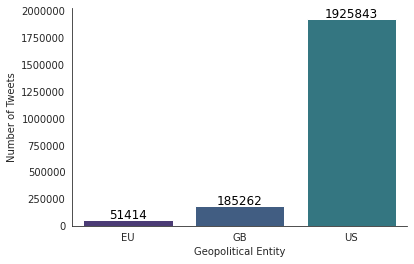

In [18]:
sns.set_palette('viridis')
sns.set_style('white')
g = sns.barplot(x='Country',y='Count',data=df_old)
plt.ylabel('Number of Tweets')
plt.xlabel('Geopolitical Entity')
plt.ticklabel_format(axis='y',style='plain')
for index, row in df_old.iterrows():
    g.text(index,row.Count+15000, row.Count,color='black', ha="center",size=12)
sns.despine()
plt.savefig('/home/juliame/framing/plots/tweet_counts_by_country_2018_2019_no_migrant.pdf',bbox_inches='tight')

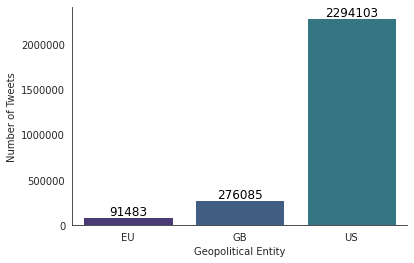

In [19]:
sns.set_palette('viridis')
sns.set_style('white')
g = sns.barplot(x='Country',y='Count',data=df_new)
plt.ylabel('Number of Tweets')
plt.xlabel('Geopolitical Entity')
plt.ticklabel_format(axis='y',style='plain')
for index, row in df_new.iterrows():
    g.text(index,row.Count+15000, row.Count,color='black', ha="center",size=12)
sns.despine()
plt.savefig('/home/juliame/framing/plots/tweet_counts_by_country_2018_2019_with_migrant.pdf',bbox_inches='tight')

In [24]:
df = df_new.merge(df_old, on='Country', suffixes=('_new', '_old'))

In [29]:
df['Percent Increase'] = 100* (df['Count_new'] - df['Count_old'])/ df['Count_old']
df.to_csv('/home/juliame/framing/intermediate_results/comparison_with_without_migrant.tsv',sep='\t')

,Country,Count_new,Count_old,Percent Increase
0,EU,91483,51414,77.934026
1,GB,276085,185262,49.024085
2,US,2294103,1925843,19.122016


In [7]:
year_total = df.groupby(['Year']).sum().reset_index()

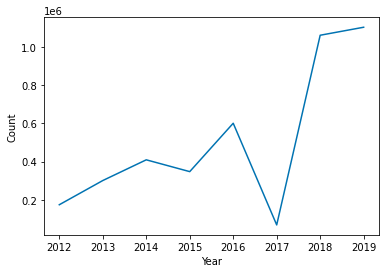

In [9]:
sns.set_palette('colorblind')
sns.lineplot(x='Year',y='Count',data=year_total)
plt.savefig('/home/juliame/framing/plots/tweet_counts_by_year.pdf')

In [104]:
full_counts

,filter,US-2012,GB-2012,EU-2012,US-2013,GB-2013,EU-2013,US-2014,GB-2014,EU-2014,...,EU-2016,US-2017,GB-2017,EU-2017,US-2018,GB-2018,EU-2018,US-2019,GB-2019,EU-2019
0,total,134962,25504,13739,241413,49650,9630,328382,68463,11922,...,20776,58667,7993,2133,935446,98258,26471,990260,86939,24939
1,no_reply,106606,15794,10187,182812,30529,7315,241855,41996,8978,...,13961,32421,3680,1343,370629,35645,11951,334666,25771,9384
2,no_url,83053,20196,8493,119759,36093,4360,164092,50247,5154,...,10572,25368,3790,784,162828,17344,4419,199471,17571,4733
3,no_photo,133952,25228,13595,236044,48695,9398,309943,65818,11333,...,18932,56039,7681,1993,920421,96981,25846,978017,86066,24437
4,no_mentions,81401,13144,8108,131249,24737,5541,172376,34542,6820,...,11907,26732,3234,1103,329776,32523,10972,307781,24450,8927
5,no_hashtags,94237,18854,8995,159330,38080,6572,214888,50034,7830,...,15534,48065,6744,1658,853774,89330,23187,921007,81605,22453


In [121]:
full_counts['count'] = full_counts.sum(axis='columns',numeric_only=True,skipna=True)
full_counts

,filter,US-2012,GB-2012,EU-2012,US-2013,GB-2013,EU-2013,US-2014,GB-2014,EU-2014,...,US-2017,GB-2017,EU-2017,US-2018,GB-2018,EU-2018,US-2019,GB-2019,EU-2019,count
0,total,134962,25504,13739,241413,49650,9630,328382,68463,11922,...,58667,7993,2133,935446,98258,26471,990260,86939,24939,4061648.0
1,no_reply,106606,15794,10187,182812,30529,7315,241855,41996,8978,...,32421,3680,1343,370629,35645,11951,334666,25771,9384,2058673.0
2,no_url,83053,20196,8493,119759,36093,4360,164092,50247,5154,...,25368,3790,784,162828,17344,4419,199471,17571,4733,1478498.0
3,no_photo,133952,25228,13595,236044,48695,9398,309943,65818,11333,...,56039,7681,1993,920421,96981,25846,978017,86066,24437,3934808.0
4,no_mentions,81401,13144,8108,131249,24737,5541,172376,34542,6820,...,26732,3234,1103,329776,32523,10972,307781,24450,8927,1695419.0
5,no_hashtags,94237,18854,8995,159330,38080,6572,214888,50034,7830,...,48065,6744,1658,853774,89330,23187,921007,81605,22453,3362896.0


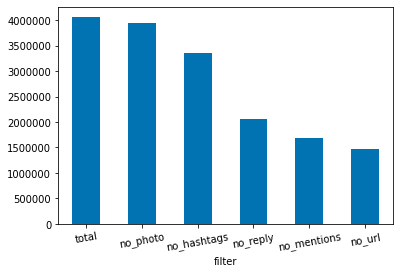

In [138]:
# fig, ax = plt.subplots()
# sns.barplot(x='filter',y='count',data=full_counts)
# ax.ticklabel_format(useOffset=False)
df = full_counts[['filter','count']].set_index('filter')
df = df.sort_values('count',ascending=False)
df.plot(kind='bar',legend=False)
plt.xticks(rotation=10)
plt.ticklabel_format(style='plain', axis='y')

In [137]:
df.sort_values('count',ascending=False)

,count
filter,
total,4061648.0
no_photo,3934808.0
no_hashtags,3362896.0
no_reply,2058673.0
no_mentions,1695419.0
no_url,1478498.0


In [10]:
df_new['Percent'] = df_new['Count'] /sum(df_new['Count']) 

In [15]:
df_new['Percent'].round(3)


0    0.034
1    0.104
2    0.862
Name: Percent, dtype: float64